# Procedures, virtualization, abstract procedures

Demonstration of using an actuate/measure procedure to get data and analyze something about the data.

The procedure itself needs to be developed and debugged. This notebook shows how to do that virtually. When ready it goes to experiment by flipping a switch.

## Experimental setup:

<img src="ledHookup.png" alt="LED" style="width: 400px;"/>

In [1]:
# Reload modules every time code is called. Set autoreload 0 to disable
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from lightlab.laboratory.virtualization import VirtualInstrument, DualInstrument
import lightlab.laboratory.virtualization as virtUtil

## Semi-libraries
That's what we're calling the files `myProcedures` and `myVirtuals`. These are python files in the same directory as this notebook that have some functions and classes. Import them to the notebook. You should be writing/developing them simultaneously with the notebook. This practice is recommended because .py files work well with `git diff` but .ipynb files do not. As a rule of thumb, don't put instrument access within the semi-libraries. You can use them for commonly used and/or long procedures, functions, sweep declarations, etc.

In [2]:
from myProcedures import extractThreshold_1, extractThreshold_2

## This is a model of a diode
It has 
* parameters, like threshold voltage
* methods for simulating: this applied voltage will give that observed current
    - apply (a.k.a. actuate) --> observe (a.k.a. measure)
    
It does not have state. 
- The observations are completely determined by the actuation _now_
- This is not a requirement 
- The only reason for a simulation model to have state is if the device you are trying to model have hysteresis (or if you are caching)

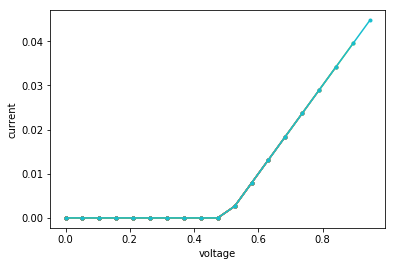

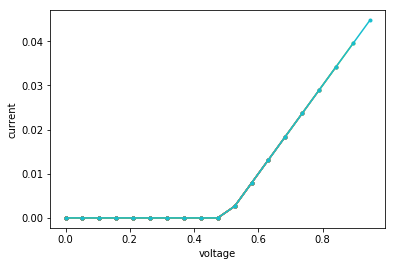

In [3]:
# To debug this procedure, you will simulate a diode similar to the real one
class Diode():
    def __init__(self, threshV, Rinline=10):
        self.threshV = threshV
        self.Rinline = Rinline
        
    def ivResponse(self, atVoltage):
        return max(0, atVoltage - self.threshV) / self.Rinline
    
myDiode = Diode(threshV=.5)

# Stone age evaluation
fi, ax = plt.subplots(figsize=(6,4))         # line 0
plt.xlabel('voltage')
plt.ylabel('current')
vArr = np.linspace(0, 1, 20)
iArr = np.zeros(len(vArr))
for jV, V in enumerate(vArr):
    iArr[jV] = myDiode.ivResponse(V)
    plt.plot(vArr[:jV], iArr[:jV], '.-')
    display.clear_output(wait=True)
    display.display(plt.gcf())               # 10 line for loop

## The parameter extraction procedure
A procedure consists of a sequence of actuation and measurement operations that interface with laboratory instruments. The actuation might be determined beforehand (i.e. sweep) or it could be changed depending on what is measured (i.e. search). 

The __procedure__ is often the most complicated part of your experimental code. The __procedure__ is what you are developing and debugging here

### Example, a parameter extraction type of procedure
In this example, we want to find the diode threshold voltage
* Acquire: do a sweep in voltage, measuring current
* Analyze: look for the maximum second-derivative

### Notes
- NdSweeper class (overkill for now) and the concept of passing methods as arguments
- These methods are NOT called yet because
    - we don't yet know if this procedure is real or virtual (it could be both)

In [4]:
extractThreshold_1?

## The virtual instrument

This class basically holds the state that is normally found in real life. It interacts with the simulation model.

#### Why do you use the Virtual instrument instead of just using the simulator?
Because this is the API for the real life instruments. You should not have to make
* prodecure 1: experimental using instruments, and
* procedure 2: virtual using a simulation model, calling things like `ivResponse()`

`VirtualKeithley` provides the same API as `Keithley` (the real instrument class)

In [5]:
class VirtualKeithley(VirtualInstrument):
    def __init__(self, viResistiveRef):
        self.viResistiveRef = viResistiveRef
        self.__appliedVoltage = 0  # state

    def setVoltage(self, volts):
        self.__appliedVoltage = volts

    def measCurrent(self):
        return self.viResistiveRef.ivResponse(self.__appliedVoltage)

#### Running it
Make a diode model, connect it to the virtual keithley, execute the procedure. Then, get the extracted parameter from the procedure. Compare it to the hidden one. We are now _evaluating_ a procedure.

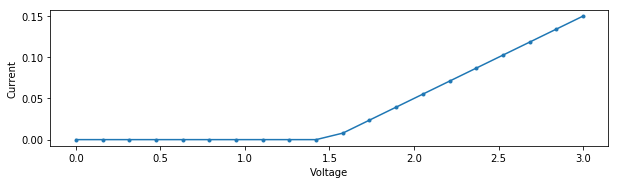

Error = 5.263157894736844 percent


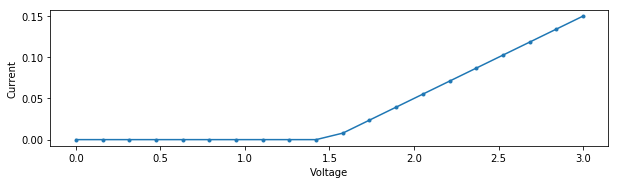

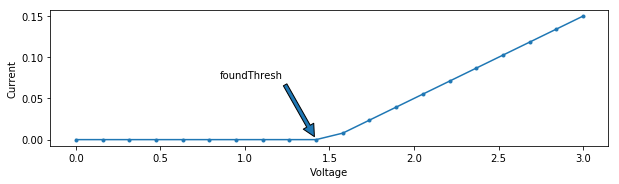

In [6]:
hiddenThresh = 1.5
myDiode = Diode(hiddenThresh)
keithley = VirtualKeithley(viResistiveRef=myDiode)

foundThresh = extractThreshold_1(keithley, vMax=3)
err = foundThresh - hiddenThresh
print('Error =', abs(err) / hiddenThresh * 100, 'percent')

## Using an abstract procedure: peakfinder
#### Passing functions as arguments, even if those functions are also procedures!

Let's do a more complicated procedure that actually needs some development. It will employ an abstract procedure: peak seaching.

Above, we defined threshold by the maximum second-derivative of current vs. voltage. The procedure did a sweep and then took the second derivative of the gathered data. The problem is that most of the points were unused, and the accuracy was not very good because the actual threshold falls between two points.

#### New procedure
This is an interactive search to find the peak second-derivative. For a given center voltage, three voltages are applied, which is enough to approximate a second-derivative at that point. That is dithering. The dither function is used with `lightlab`'s peak searcher (Nelder-Meade/swarm) to quickly and very accurately find the threshold.

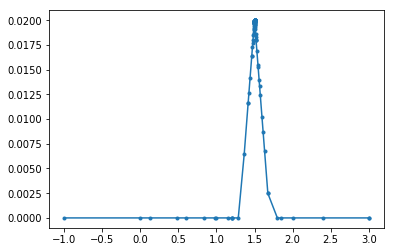

Error = 0.0031412012669799574 percent


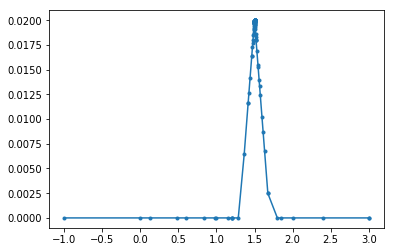

In [7]:
foundThresh = extractThreshold_2(keithley)
err = foundThresh - hiddenThresh
print('Error =', err / hiddenThresh * 100, 'percent')

## Warning the following cells access real instruments
(This warning should be apparent in all your notebooks)

You can prevent any hardware access using the `virtualization.virtualOnly` variable.

In [8]:
virtUtil.virtualOnly = True

### The hardware instrument
Is pulled from the instruments_dict. In this case, "Keithley 23." You need to build this dict elsewhere using the tools from `lightlab.laboratory.state`. We don't just want a `VirtualInstrument`, we want something that can switch between virtual and real on the fly. That is a `DualInstrument`.

In [9]:
if not virtUtil.virtualOnly:
    from lightlab.laboratory.state import lab
    dualKeithley = DualInstrument(real_obj=lab.instruments_dict['Keithley 23'], 
                                   virt_obj=VirtualKeithley(myDiode))
    with dualKeithley.asReal():
        dualKeithley.setVoltage(0.)
        dualKeithley.setProtectionCurrent(50e-3)
        print('First guess =', extractThreshold_1(dualKeithley), 'Volts')
else:
    dualKeithley = DualInstrument(virt_obj=VirtualKeithley(myDiode))

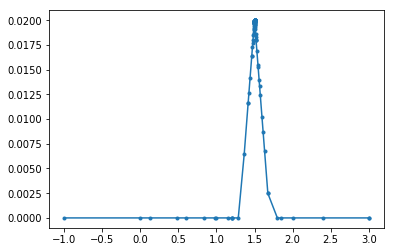

The model threshold is 1.5000471180190047


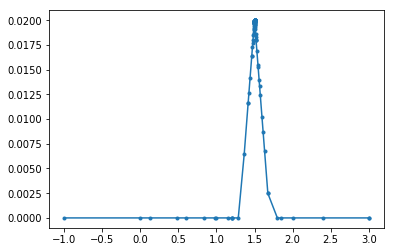

In [10]:
with dualKeithley.asVirtual():
    foundModel = extractThreshold_2(dualKeithley)
    print('The model threshold is', foundModel)
with dualKeithley.asReal():
    foundDevice = extractThreshold_2(dualKeithley)
    print('The device threshold is', foundDevice)